In [1]:
import sys
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import Tensor
from torch.utils.data import DataLoader, random_split

modules_path = 'C:/Users/PMLS/FYP/Modules/'
dataset_path = 'C:/Users/PMLS/FYP/Dataset/STMM'
save_path = "C:/Users/PMLS/FYP/Models"

sys.path.insert(1, modules_path)
from video_dataset import VideoFrameDataset, ImglistToTensor

if False and torch.xpu.is_available():
    device = torch.device("xpu")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\PMLS\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


cpu


In [2]:
# Load dataset
#img_w = 640
#img_h = 480
#frames_per_video = 7
batch_size = 10

dataset = VideoFrameDataset(
    root_path= f"{dataset_path}",
    annotationfile_path=f"{dataset_path}/annotations.txt",
    num_segments=8,
    frames_per_segment=1,
    imagefile_template='{:01d}.jpg',
    transform=ImglistToTensor(),
    test_mode=False
)
class_map = {0:"down", 1:"left", 2:"right", 3:"up"}

train_dataset, valid_dataset, test_dataset = random_split(dataset, [0.1,0.2,0.7])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [5]:
# Define transforms
import cv2
import pywt
def wavelet_transform(batch):
        batch2=[]
        for frame in batch:
            A, B = pywt.dwt(frame, 'db1')
            batch2.append(B)
        return np.array(batch2)

def grey_transform(batch):
    batch = batch.transpose(0,1,3,4,2)
    favg = np.average(batch[0], axis=0)
    grey_avg = cv2.cvtColor(favg, cv2.COLOR_BGR2GRAY)
    batch2 = []
    for frame in batch[0]:
        frame2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame2 = frame2 - grey_avg
        threshhold = np.max(frame2) * 0.05
        _, frame2 = cv2.threshold(frame2, threshhold, 255, cv2.THRESH_BINARY)
        batch2.append(frame2)
    return np.array([batch2])
    
def local_transform(batch):
    batch = np.array(batch.cpu())
    new_batch = []
    for b in batch:
        #b=grey_transform(batch)
        b = wavelet_transform(b)
        new_batch.append(b)
    return torch.tensor(np.array(new_batch))

In [9]:
def myflat1(x):
    y = []
    for frame in x:
        y.append([])
        for channel in frame:
            y[-1].append(channel.flatten())
    return np.average(y,axis=(0,1))

def downsample(x, p):
    y = []
    for i in x:
        if np.random.rand() < p:
            y.append(i)
    return np.array(y)

def class_param(x):
    x = np.array(x)
    x = myflat1(x)
    x = downsample(x.T,0.2).T
    return x

x,label = train_dataset[2]
x = np.array(x)
print(class_map[label])
x=myflat1(x)
print(x.shape)
x=downsample(x.T,0.2).T
print(x.shape)

up
(307200,)
(61379,)


In [ ]:
param_by_label = {}
count = {0:0,1:0,2:0,3:0}

i=0
for x,label in train_dataset:
    i+=1
    x = class_param(x)
    
    try: param_by_label[label] += x
    except: param_by_label[label] = x
    count[label] += 1

for k in param_by_label:
    param_by_label[k] = param_by_label[k]/count[k]

In [74]:
train_avg = 0
train_var = []
for x,label in train_dataset:
    train_avg += np.average(x)
    train_var.append(np.var(np.array(x)))
print(train_avg/len(train_dataset))
print(sum(train_var)/len(train_dataset))

0.4600902073814169
0.06473251820906349


(8, 3, 480, 640)


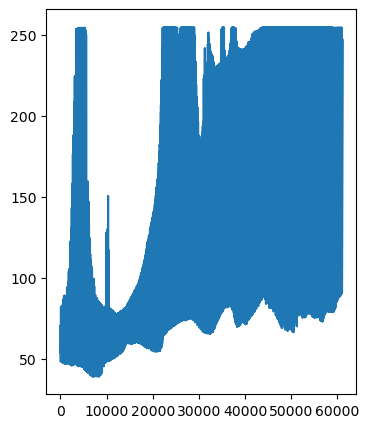

In [25]:
def captureVideo():
    # Captures videos
    batch = []
    video = []
    i=0
    while i/frames_per_video < 1:
        i+=1
        # Capture a frome
        ret, frame = cam.read()
        
        # Display the captured frame
        cv2.imshow('Camera', frame)
        frame = np.array(frame, dtype=np.float32)
        frame = cv2.resize(frame, (img_w, img_h))
        time.sleep(1/frame_rate)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video.append(frame)
        if len(video)==frames_per_video:
            video = np.array(video).transpose(0,3,1,2)
            global cam_sample
            print(video.shape)
            cam_sample = class_param(video)
            plt.figure(1,figsize=(4,5))
            plt.plot(cam_sample)
            
        # Press 'q' to exit the loop
        if cv2.waitKey(1) == ord('q'):
            break
            
    cam.release()
    cv2.destroyAllWindows()

# Run
img_w = 640
img_h = 480
frames_per_video = 8
frame_rate = 10

# Open the default camera
cam = cv2.VideoCapture(0)

try:
    captureVideo()
except Exception as e:
    print("Error:", e)
    cam.release()
    cv2.destroyAllWindows()

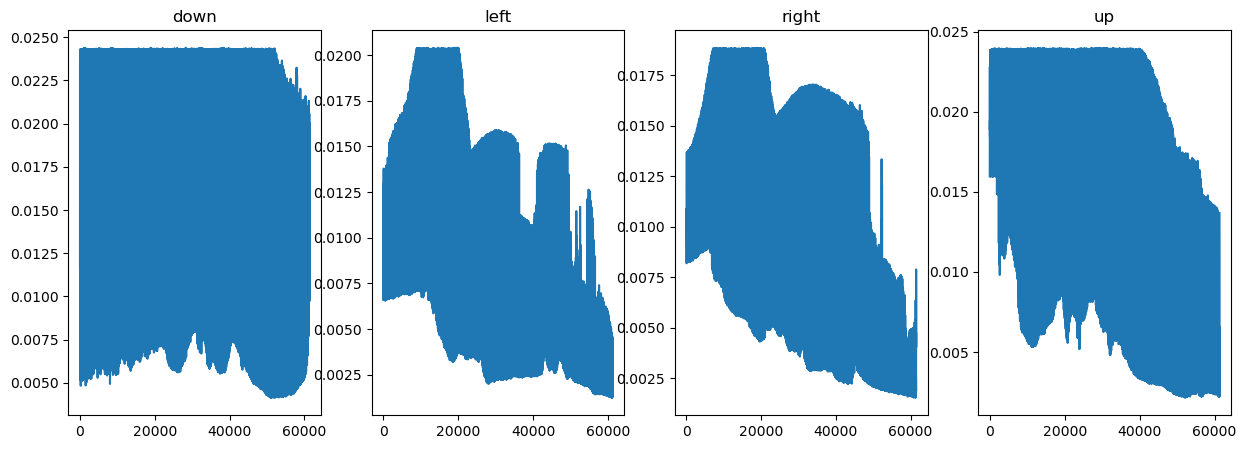

In [17]:
x = param_by_label
plt.figure(1,figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(x[i])
    plt.title(class_map[i])

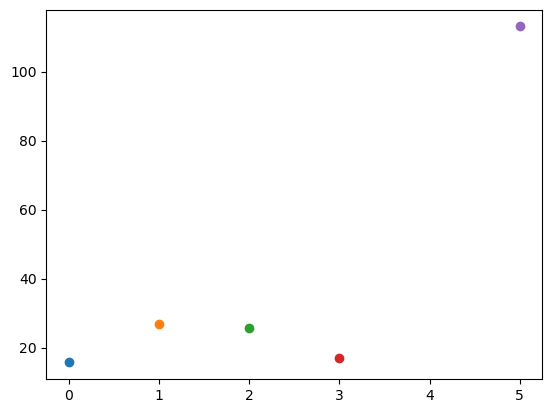

In [68]:
for i in range(4):
    plt.plot(i,param_by_class[i], 'o')
plt.plot(5, cam_sample, 'o')